# OASIS-3
___

**Summary:** OASIS-3 is a retrospective compilation of data for >1000 participants that were collected across several ongoing projects through the WUSTL Knight ADRC over the course of 30 years. Participants include 609 cognitively normal adults and 489 individuals at various stages of cognitive decline ranging in age from 42-95yrs. All participants were assigned a new random identifier and all dates were removed and normalized to reflect days from entry into study. The dataset contains over 2000 MR sessions which include T1w, T2w, FLAIR, ASL, SWI, time of flight, resting-state BOLD, and DTI sequences. Many of the MR sessions are accompanied by volumetric segmentation files produced through Freesurfer processing. PET imaging from 3 different tracers, PIB, AV45, and FDG, totaling over 1500 raw imaging scans and the accompanying post-processed files from the Pet Unified Pipeline (PUP) are also available in OASIS-3.
<br><br>
For analysis, Alzheimer's disease (AD) patients were upsampled to balance the dataset.
<br><br>
### Diagnosis Labeling<br>
___
The field 'dx1' was used as the primary diagnostic for this study. All variables in this diagnostic field were assigned either 0 for healthy descriptor, 1 for AD as the primary diagnosis, or 2 for non-healthy, non-AD diagnosis, which may include Parkinson's or vascular dementia. The elements and their attributions can be found in a dictionary in the **Diagnosis Labeling** section of this study. These attributions were given for each individual clinical session per patient.
<br><br>
```python
diagnosis_qual={0:'Cognitively Normal', 1:'Alzheimer\'s Diagnosis', 2.:'Non-Healthy, Non-Alzheimer\'s Disease'}
```
<br>
Many patients had diagnoses that changed during the course of the study or included a mix of AD and other forms of dementia over different clinical visits. In order to provide for clean data, if the number of cumulative AD diagnoses (value of 1) was greater than the total number of non-healthy, non-AD diagnoses (value of 2), the patient was assigned a diagnosis of 1 for AD across all their clinical visits, and vice versa with the ascription of 2 for a non-healthy, non-AD. This value would override the attributions for every clinical visit for each patient so that each patient had just one diagnostic value. 

For those patients who were described as cognitively normal at the beginning of the study, but were then later diagnosed as having AD, with the number of total AD diagnoses greater than the total number of non-healthy, non-AD descriptors for that patient, these patients were assigned a 3 for 'converted.'
```python
diagnosis_qual={0:'Cognitively Normal', 1:'Alzheimer\'s Diagnosis', 2:'Non-Healthy, Non-Alzheimer\'s Disease', 3:'Converted'}
```
<br>

A more detailed description can be found in the code below.

# Environment Setup and Data Import

In [1]:
import random
random.seed(50)
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import plotly.plotly as py
import plotly.graph_objs as go
import os
import seaborn as sns
import scipy
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from collections import Counter

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [2]:
cd '/Users/glynismattheisen/Desktop/Final2'

/Users/glynismattheisen/Desktop/Final2


In [3]:
df_FS = pd.read_csv('norm_vol_final.csv') # import freesurfer data
df_age = pd.read_csv('age.csv') # import age data
df_clin = pd.read_csv('gmattheisen_12_1_2018_15_52_40.csv') # import clinical data (includes diagnosis values)

In [4]:
def get_SESS_ID(file_name): # parse out session id from MR or FS ID
    return file_name[:9] + file_name[-5:]

df_age['MR'] = df_age['MR ID'].apply(get_SESS_ID) # convert long form MR ID to session id
df_FS['MR'] = df_FS['FS_FSDATA ID'].apply(get_SESS_ID)# convert long form FS ID to session id

In [5]:
def replace_null(column): # fill null values with MEAN +/- STD
    mean = column.mean()
    std = column.std()
    is_null = column.isnull().sum()
    rand_VAR = np.random.randint(mean - std, mean + std, size = is_null)
    VAR_slice = column.copy()
    VAR_slice[np.isnan(VAR_slice)] = rand_VAR
    column = VAR_slice
    column = column.astype(int)
    return column

In [6]:
del df_age['MR ID'], df_age['Subject'] # not needed
del df_clin['Age'], df_clin['Date'] # mostly null

df_FS.set_index('MR', inplace=True)
df_age.set_index('MR', inplace=True)

df_age['Age'] = replace_null(df_age['Age']) # fill null age values with MEAN +/- STDd
assert df_age["Age"].isnull().sum() ==0  # confirm null values count = 0

df_FS = df_FS.merge(df_age, left_index=True, right_index=True, how='inner') # add age to Freesurfer data
df_FS.set_index(['FS_FSDATA ID'], inplace=True)

# Diagnosis Labeling

In [7]:
df_clin['dx1'].fillna('empty', inplace=True) # two null elements are patients with no other clinical diagnostic data
diag_descriptors = df_clin['dx1'].unique() # list of all diagnostic values

diagnosis_dict = {} # create dictionary with key for each diagnostic option
for x in diag_descriptors:
    diagnosis_dict[x] = ''

healthy_diag  = ['Cognitively normal' ,
                 'No dementia', 
                 'uncertain dementia',
                 'Unc: ques. Impairment'] # list of healthy descriptors

alz_diag = ['AD Dementia','AD dem Language dysf prior',
            'AD dem Language dysf with','AD dem w/oth (list B) not contrib',
            'AD dem w/oth unusual features','AD dem visuospatial, after',
           'AD dem w/oth unusual features/demt on',
           'AD dem w/Frontal lobe/demt at onset',
           'AD dem/FLD prior to AD dem',
            'AD dem w/oth unusual feat/subs demt',
            'AD dem w/depresss- not contribut',
            'AD dem distrubed social- with',
            'AD dem distrubed social- prior',
            'AD dem w/CVD not contrib',
            'AD dem w/CVD contribut',
            'AD dem visuospatial- with',
            'AD dem visuospatial- prior',
            'AD dem Language dysf after',
            'AD dem w/oth (list B) contribut',
            'AD dem distrubed social- after',
            'AD dem w/depresss- contribut',
            'AD dem w/depresss  not contribut',
            'AD dem w/depresss  contribut',
            'AD dem w/PDI after AD dem contribut',
            'AD dem w/PDI after AD dem not contrib',
            'AD dem w/depresss, not contribut',
            'DAT w/depresss not contribut',
            'DAT' # DAT = dementia alzheimer's type
           ] # list of AD descriptors


misc_diag = ['DLBD, primary',
             'DLBD- primary',
             'DLBD- secondary',
             'Frontotemporal demt. prim',
             'Unc: impair reversible',
             'AD dem cannot be primary',
             'Non AD dem- Other primary',
             'Incipient Non-AD dem',
             'Incipient demt PTP', # mild cognitive impairment
             '.',
             'uncertain- possible NON AD dem',
             'Vascular Demt- primary',
             '0.5 in memory only',
             'Vascular Demt- secondary',
             'Vascular Demt  primary',
             'Dementia/PD- primary',
             'uncertain  possible NON AD dem',
             'empty'
            ] # list of misc descriptors (generally PD or vascular dementia)
             
for x in healthy_diag:
    diagnosis_dict[x] = 0 # assign 0 to keys in diagnosis_dict belonging to healthy descriptors list

for x in alz_diag:
    diagnosis_dict[x] = 1 # assign alzheimer's descriptors diagnosis 1

for x in misc_diag:
    diagnosis_dict[x]= 2 # assign non-healthy, non-alzheimer's diagnoses a 2

diags = [] # use the diagnostic dictionary to create list of all labels for elements in df_clin
for i in df_clin['dx1']:
    diags.append(diagnosis_dict[i])

df_clin['label'] = pd.DataFrame(diags) # add labels to df_clin as new column 

In [8]:
Subjects = df_clin['Subject'].unique() # Determine unique subjects

"""this code takes all the diagnostics for each visit for each patient and summarizes them such 
that each patient gets just one diagnostic value across all visits"""
for subj in range(0,1098):     # find the entries for each subject
    values = np.where(df_clin['Subject'] == Subjects[subj])[0]     # put entries in list
    diag_nums = []   # list of labels for each subject
    for i in values:
        diag_nums.append(df_clin['label'].iloc[i])
    if diag_nums.count(2) != 0 or diag_nums.count(1) != 0: 
        if diag_nums.count(0) == 0:
            if diag_nums.count(1) >= diag_nums.count(2): # if number of alz diagnoses greater than number of misc >> diagnose alz
                for i in values:
                    df_clin['label'][i] = 1 # our new 'converted group'
            elif diag_nums.count(2) > diag_nums.count(1): # if number of misc diagnoses greater than number of alz >> diagnose misc
                for i in values:
                    df_clin['label'][i] = 2
        elif diag_nums.count(0) != 0:
            if diag_nums.count(2) > diag_nums.count(1): # if number of alz diagnoses greater than number of misc >> diagnose alz
                for i in values:
                    df_clin['label'][i] = 2 # our new 'converted group'
            elif diag_nums.count(1) >= diag_nums.count(2): # if number of misc diagnoses greater than number of alz >> diagnose misc
                for i in values:
                    df_clin['label'][i] = 3
    
df_clin.to_csv('clinical_w_Conv_diag.csv') # write to file

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: 

In [9]:
"""create a new dictionary of these summary diagnostic values 
for each patient"""

diag = [] # make file of just subjects with diagnoses
for subj in range(0,1098):
    values = np.where(df_clin['Subject'] == Subjects[subj])  # find the entries for each subject
    diag.append(df_clin['label'].iloc[values[0][0]])

Subject_dict = {}
for num in range(0,1098):
    Subject_dict[Subjects[num]] = diag[num] # dictionary with subjects as keys and diagnoses as values

## Combine Freesurfer Data with Diagnostic Data

In [10]:
diagnosis = [] 
for i in df_FS['Subject']:
    diagnosis.append(Subject_dict[i])
    
diagnosis = pd.DataFrame(diagnosis)
df_FS['Diagnosis'] = diagnosis.values # add column of diagnoses to freesurfer data

df_FS = df_FS[df_FS.Diagnosis != 2] # take out miscellaneous diagnoses

df_FS_conv = df_FS[df_FS.Diagnosis == 3] # df of only converted patients
df_FS_wo_conv = df_FS[df_FS.Diagnosis != 3] # df without conv diagnoses

In [11]:
conv_subj_ids = df_FS_conv['Subject'].unique() # list of each converted subject id

first_instance = [] # list first instance for each subject in converted
for i in conv_subj_ids:
    first_instance.append(np.where(df_FS_conv['Subject'] == i)[0][0]) 
    
conv_data = [] # list data for first instance of converted subj 
for i in first_instance:
    conv_data.append(df_FS_conv.iloc[i])
    
first_instance_df = pd.DataFrame(conv_data) # create df of data for first instance of those converted

In [12]:
instances = [] # list instances for each subject in converted
for i in conv_subj_ids:
    instances.append(np.where(df_FS_conv['Subject'] == i)[0]) 

instances_2 = []  # unpack values
for i in instances:
    if len(i) == 1:
        instances_2.append(i)
    else:
        instances_2.append(i[1:])
        
last_instance =[] # unpack values to get list of last instance for each converted subj
for i in instances_2:
    for x in i:
        last_instance.append(x)
        
conv_data = [] # list data for instance of converted subj 
for i in last_instance:
    conv_data.append(df_FS_conv.iloc[i])

last_instance_df = pd.DataFrame(conv_data)

last_instance_whole_df = df_FS_wo_conv.append(last_instance_df) # add back in conv patients last instances

for x,i in enumerate(last_instance_whole_df['Diagnosis']): # convert 3 values back to 1 for AD
    if i == 3:
        last_instance_whole_df['Diagnosis'][x] = 1

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [13]:
# upsample AD to make balanced set
AD_head = last_instance_whole_df.sort_values(by='Diagnosis', ascending = False).head(381) # all subjects diagnosed as alz
AD_head_rem = last_instance_whole_df.sort_values(by='Diagnosis', ascending = False).head(288) # remainder needed to balance

lI_whole_bal_df = last_instance_whole_df.append(AD_head)
lI_whole_bal_df = lI_whole_bal_df.append(AD_head)
lI_whole_bal_df = lI_whole_bal_df.append(AD_head_rem)

assert len(lI_whole_bal_df[lI_whole_bal_df['Diagnosis'] == 1]) == len(lI_whole_bal_df[lI_whole_bal_df['Diagnosis'] == 0]) # ensure balanced

# Correlations

In [14]:
corr = lI_whole_bal_df.corr() # what values correlate with diagnosis?
corr

,lhCortexVol_norm_ICV,rhCortexVol_norm_ICV,CortexVol_n_ICV,TotalGray_norm_ICV,SupraTentorialVol_norm_ICV,lhCorticalWhiteMatterVol_norm_ICV,rhCorticalWhiteMatterVol_norm_ICV,Age,Diagnosis
lhCortexVol_norm_ICV,1.000000,0.970578,0.992772,0.964323,0.870576,0.607895,0.594508,-0.558945,-0.511702
rhCortexVol_norm_ICV,0.970578,1.000000,0.992461,0.961015,0.863141,0.586503,0.587678,-0.556773,-0.497995
CortexVol_n_ICV,0.992772,0.992461,1.000000,0.969845,0.873344,0.601753,0.595525,-0.562019,-0.508675
TotalGray_norm_ICV,0.964323,0.961015,0.969845,1.000000,0.877081,0.651710,0.648765,-0.589593,-0.497301
SupraTentorialVol_norm_ICV,0.870576,0.863141,0.873344,0.877081,1.000000,0.867675,0.866351,-0.604418,-0.495829
lhCorticalWhiteMatterVol_norm_ICV,0.607895,0.586503,0.601753,0.651710,0.867675,1.000000,0.977208,-0.577784,-0.419120
rhCorticalWhiteMatterVol_norm_ICV,0.594508,0.587678,0.595525,0.648765,0.866351,0.977208,1.000000,-0.579381,-0.409224
Age,-0.558945,-0.556773,-0.562019,-0.589593,-0.604418,-0.577784,-0.579381,1.000000,0.436388
Diagnosis,-0.511702,-0.497995,-0.508675,-0.497301,-0.495829,-0.419120,-0.409224,0.436388,1.000000


In [15]:
columns = corr.columns.values

z = [-0.412148,-0.402058,-0.409204,-0.392236,-0.392708,-0.324860,-0.318144,0.360485,1.000000]

list_n = [item*150 for item in z] 

abs_list = lambda x :abs(x) # normalize x values

for x, i in enumerate(list_n):
    list_n[x] = abs(i)

In [16]:
z = [-0.412148,-0.402058,-0.409204,-0.392236,-0.392708,-0.324860,-0.318144,0.360485,1.000000]
trace0 = go.Scatter(
    x=[0,0,0,0,0,0,0,0,0],
    y=[0,1,2,3,4,5,6,7,8,9],
    text=columns,
    hoverinfo = 'y',
    textposition=['bottom center','top center','middle center','bottom center','bottom center','middle center','middle center','middle center','middle center'],
    mode='markers + text',
    marker=dict(
        color =[300,325,375,275,325,350,350,350,350],
        opacity=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        size=list_n,
        showscale=False

    )
)

layout = go.Layout(
    xaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks='',
        showticklabels=False
    ),
    yaxis=dict(
        range=[-25,25],
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks='',
        showticklabels=False
    )
)

data = [trace0]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bubblechart-color')


/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5, 1.0, 'Diagnosis and Age')

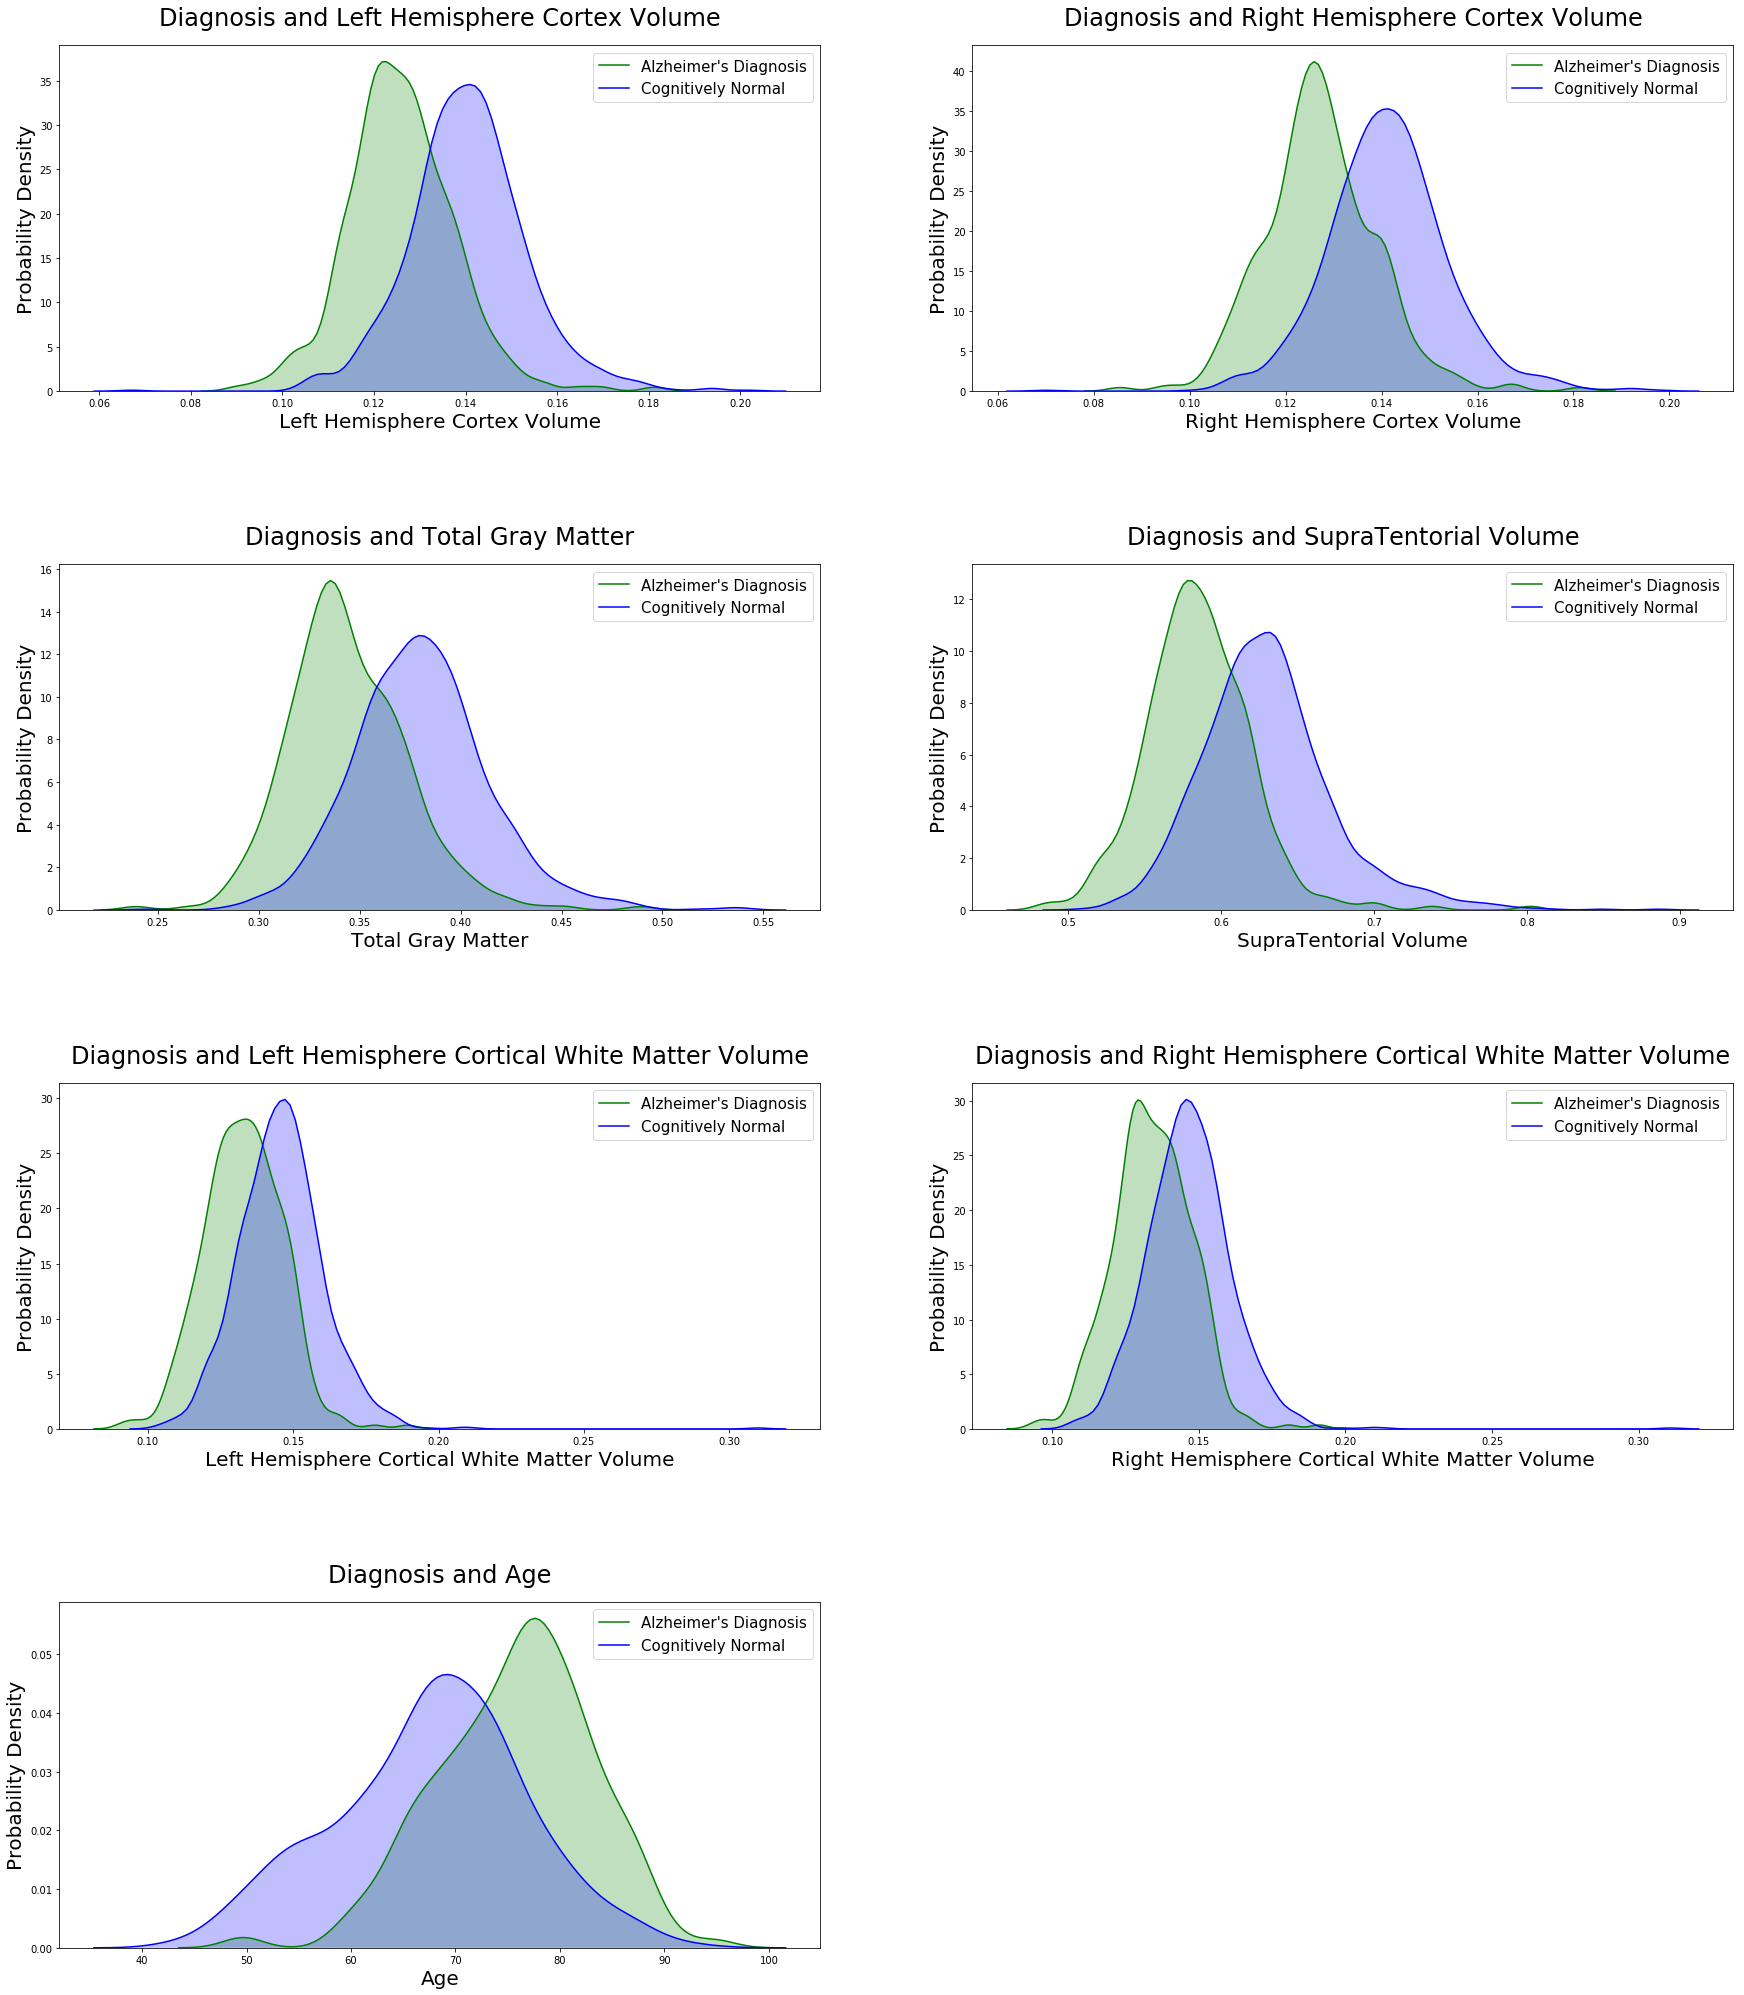

In [17]:
healthy = 'Cognitively Normal'
dementia = 'Alzheimer\'s Diagnosis'

fig = plt.figure(figsize=(30, 35))
grid = plt.GridSpec(4, 2, wspace=0.2, hspace=0.5)

plt.subplot(grid[0, 0])
ax = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==1.0].lhCortexVol_norm_ICV, label = dementia, color='green', shade=True)
ax = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==0.0].lhCortexVol_norm_ICV, label = healthy, color ='blue', shade=True)
ax.legend(fontsize=15)
plt.xlabel('Left Hemisphere Cortex Volume', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax.set_title('Diagnosis and Left Hemisphere Cortex Volume', fontsize=24, pad = 20)

plt.subplot(grid[0, 1])
ax1 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==1.0].rhCortexVol_norm_ICV, label = dementia, color='green', shade=True)
ax1 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==0.0].rhCortexVol_norm_ICV, label = healthy, color='blue', shade=True)
ax1.legend(fontsize=15)
plt.xlabel('Right Hemisphere Cortex Volume', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax1.set_title('Diagnosis and Right Hemisphere Cortex Volume', fontsize=24, pad = 20)

plt.subplot(grid[1, 0])
ax2 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==1.0].TotalGray_norm_ICV, label = dementia, color='green', shade=True)
ax2 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==0.0].TotalGray_norm_ICV, label = healthy, color='blue', shade=True)
ax2.legend(fontsize=15)
plt.xlabel('Total Gray Matter', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax2.set_title('Diagnosis and Total Gray Matter', fontsize=24, pad = 20)


plt.subplot(grid[1, 1])
ax = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==1.0].SupraTentorialVol_norm_ICV, label = dementia, shade=True, color='green')
ax = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==0.0].SupraTentorialVol_norm_ICV, label = healthy, shade=True, color ='blue')
plt.xlabel('SupraTentorial Volume', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax.legend(fontsize=15)
ax.set_title('Diagnosis and SupraTentorial Volume', fontsize=24, pad = 20)

plt.subplot(grid[2, 0])
ax1 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==1.0].lhCorticalWhiteMatterVol_norm_ICV, label = dementia, shade=True,color='green')
ax1 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==0.0].lhCorticalWhiteMatterVol_norm_ICV, label = healthy, shade=True,color='blue')
plt.xlabel('Left Hemisphere Cortical White Matter Volume', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax1.legend(fontsize=15)
ax1.set_title('Diagnosis and Left Hemisphere Cortical White Matter Volume', fontsize=24, pad = 20)

plt.subplot(grid[2, 1])
ax1 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==1.0].rhCorticalWhiteMatterVol_norm_ICV, label = dementia, shade=True,color='green')
ax1 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==0.0].rhCorticalWhiteMatterVol_norm_ICV, label = healthy, shade=True,color='blue')
plt.xlabel('Right Hemisphere Cortical White Matter Volume', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax1.legend(fontsize=15)
ax1.set_title('Diagnosis and Right Hemisphere Cortical White Matter Volume', fontsize=24, pad = 20)


plt.subplot(grid[3, 0])
ax1 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==1.0].Age, label = dementia, shade=True,color='green')
ax1 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==0.0].Age, label = healthy, shade=True,color='blue')
plt.xlabel('Age', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax1.legend(fontsize=15)
ax1.set_title('Diagnosis and Age', fontsize=24, pad = 20)



/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5, 1.0, 'Diagnosis and Age')

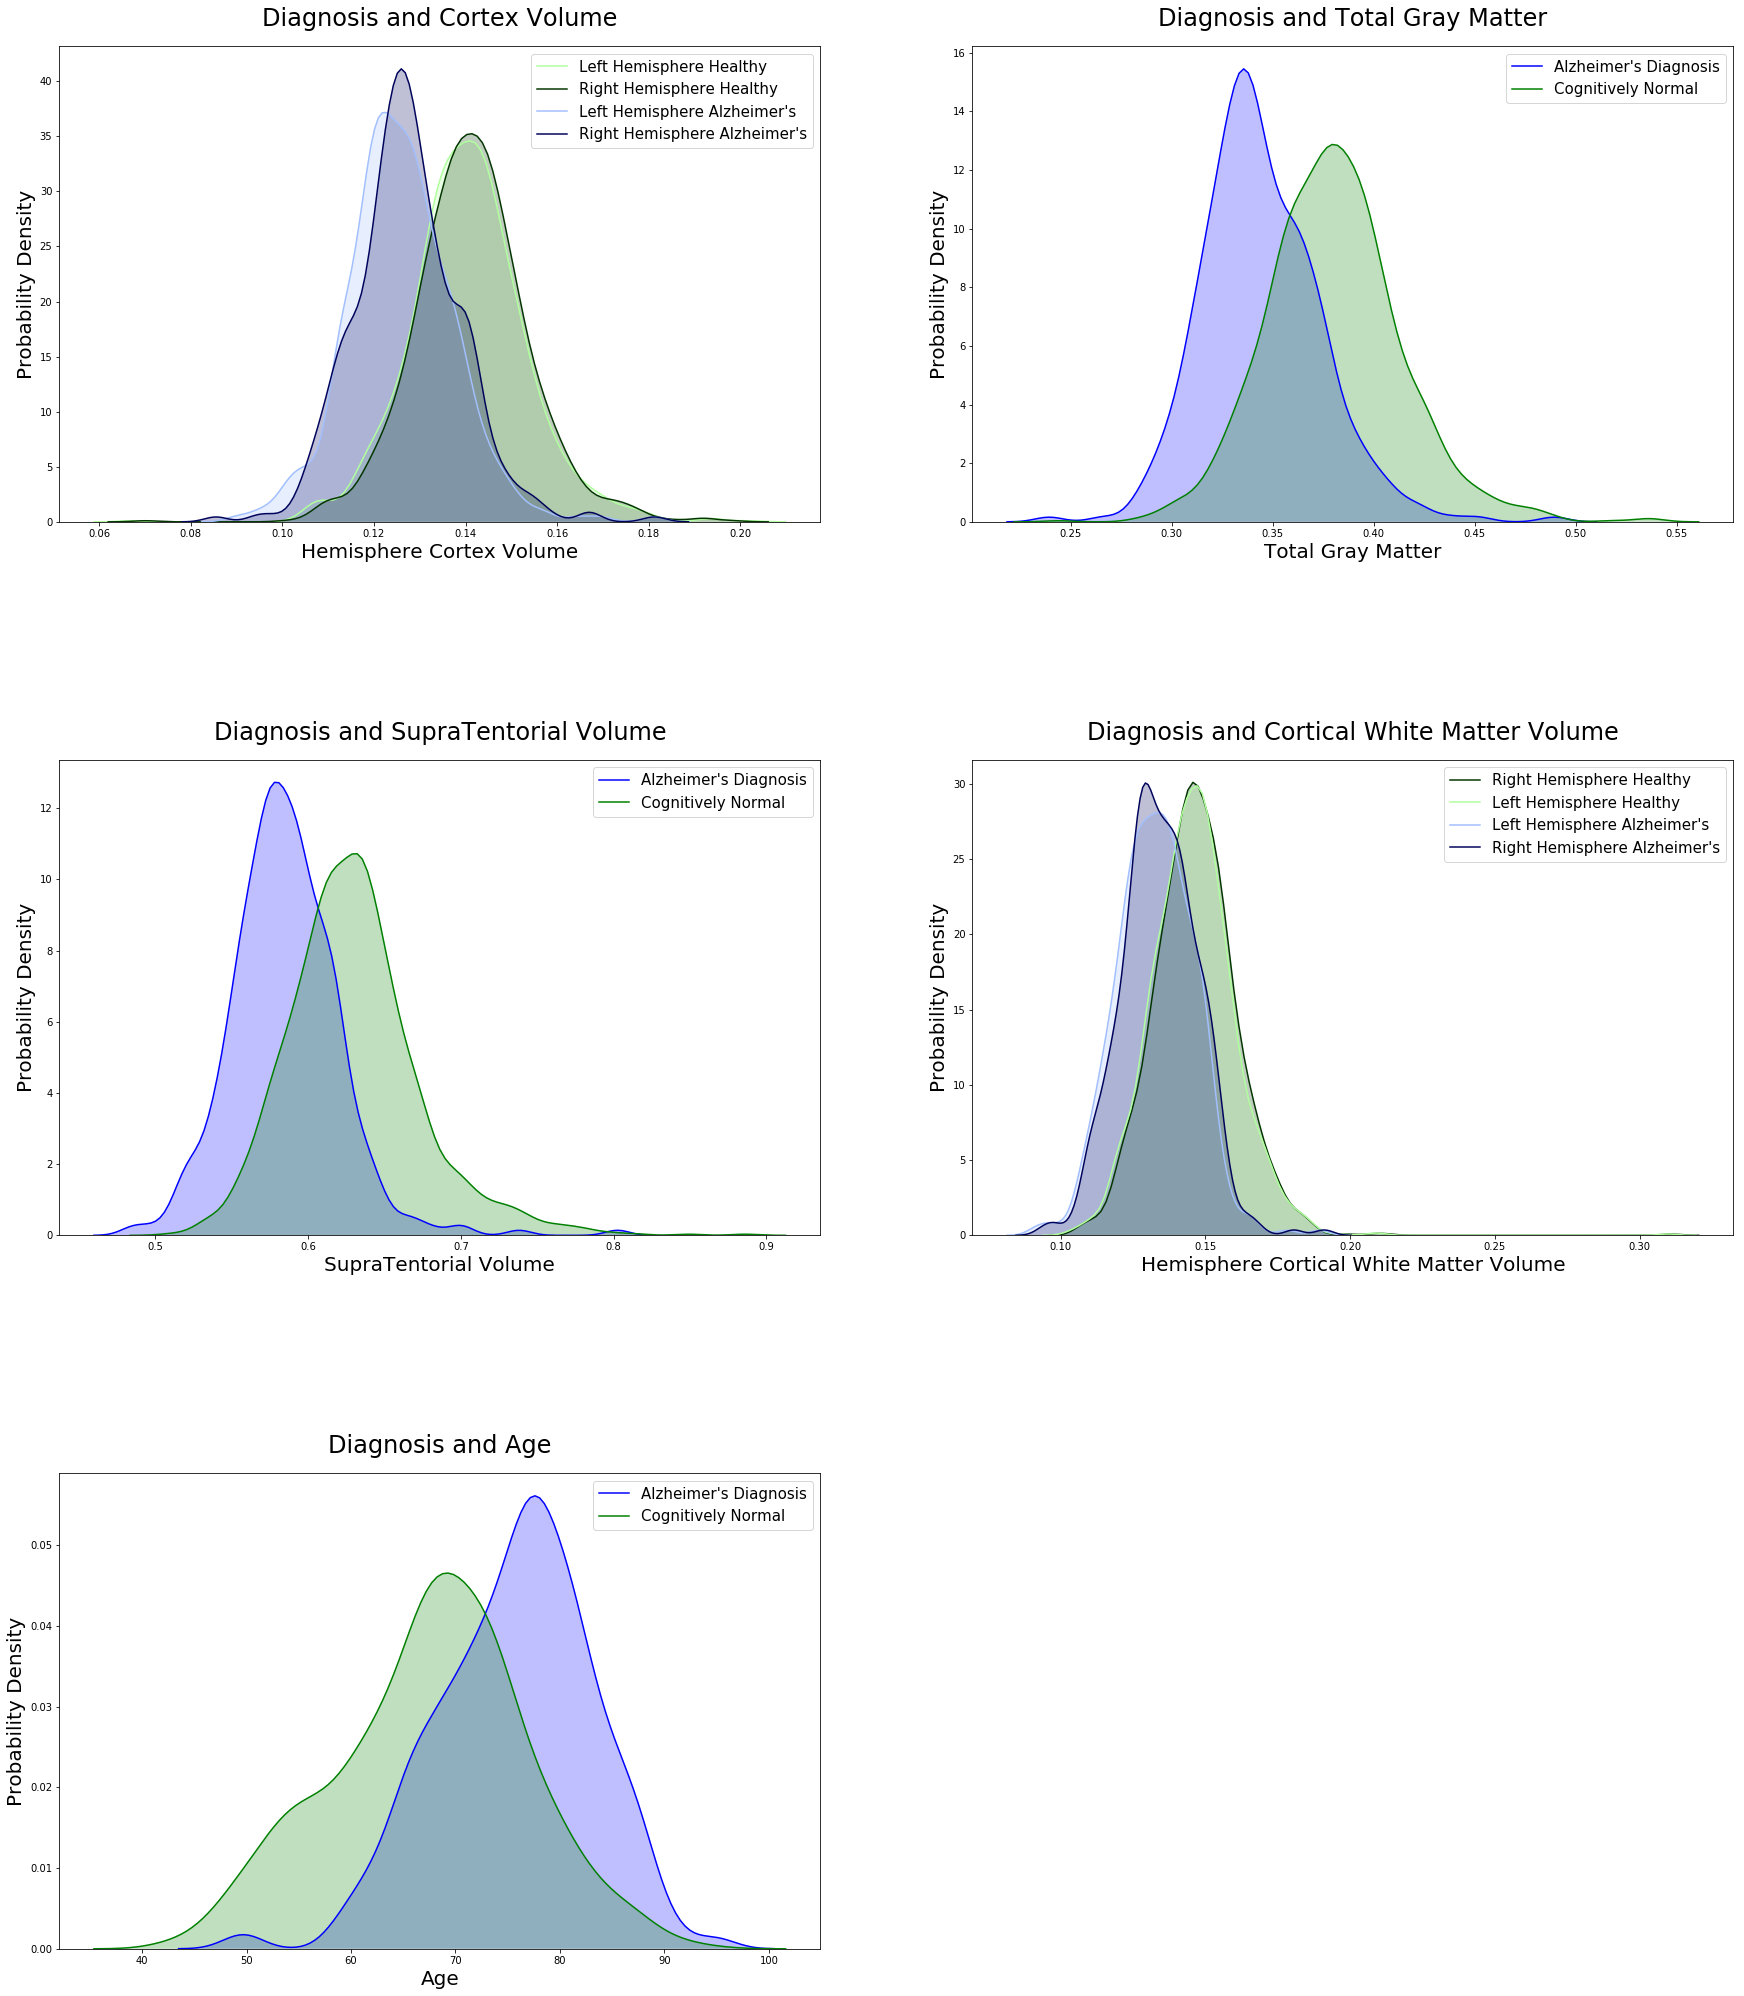

In [18]:
healthy = 'Cognitively Normal'
dementia = 'Alzheimer\'s Diagnosis'
left_h = 'Left Hemisphere Healthy'
left_a = 'Left Hemisphere Alzheimer\'s'
right_h = 'Right Hemisphere Healthy'
right_a = 'Right Hemisphere Alzheimer\'s'

fig = plt.figure(figsize=(30, 35))
grid = plt.GridSpec(3, 2, wspace=0.2, hspace=0.5)

plt.subplot(grid[0, 0])

ax = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==0.0].lhCortexVol_norm_ICV, label = left_h, color =sns.xkcd_rgb["pastel green"], shade=True, legend='lh')
ax = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==0.0].rhCortexVol_norm_ICV, label = right_h, color=sns.xkcd_rgb["dark green"], shade=True, legend='rh')

ax = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==1.0].lhCortexVol_norm_ICV, label = left_a, color=sns.xkcd_rgb["pastel blue"], shade=True, legend='lh')
ax = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==1.0].rhCortexVol_norm_ICV, label = right_a, color=sns.xkcd_rgb["dark blue"], shade=True, legend='rh')
ax.legend(fontsize=15)
plt.xlabel('Hemisphere Cortex Volume', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax.set_title('Diagnosis and Cortex Volume', fontsize=24, pad = 20)


plt.subplot(grid[0, 1])
ax2 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==1.0].TotalGray_norm_ICV, label = dementia, color='blue', shade=True)
ax2 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==0.0].TotalGray_norm_ICV, label = healthy, color='green', shade=True)
ax2.legend(fontsize=15)
plt.xlabel('Total Gray Matter', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax2.set_title('Diagnosis and Total Gray Matter', fontsize=24, pad = 20)


plt.subplot(grid[1, 0])
ax = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==1.0].SupraTentorialVol_norm_ICV, label = dementia, shade=True, color='blue')
ax = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==0.0].SupraTentorialVol_norm_ICV, label = healthy, shade=True, color ='green')
plt.xlabel('SupraTentorial Volume', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax.legend(fontsize=15)
ax.set_title('Diagnosis and SupraTentorial Volume', fontsize=24, pad = 20)

plt.subplot(grid[1, 1])
ax1 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==0.0].rhCorticalWhiteMatterVol_norm_ICV, label = right_h, shade=True,color=sns.xkcd_rgb["dark green"])
ax1 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==0.0].lhCorticalWhiteMatterVol_norm_ICV, label = left_h, shade=True,color=sns.xkcd_rgb["pastel green"])
ax1 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==1.0].lhCorticalWhiteMatterVol_norm_ICV, label = left_a, shade=True,color=sns.xkcd_rgb["pastel blue"])
ax1 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==1.0].rhCorticalWhiteMatterVol_norm_ICV, label = right_a, shade=True,color=sns.xkcd_rgb["dark blue"])
plt.xlabel('Hemisphere Cortical White Matter Volume', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax1.legend(fontsize=15)
ax1.set_title('Diagnosis and Cortical White Matter Volume', fontsize=24, pad = 20)

plt.subplot(grid[2, 0])
ax1 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==1.0].Age, label = dementia, shade=True,color='blue')
ax1 = sns.kdeplot(lI_whole_bal_df[lI_whole_bal_df['Diagnosis']==0.0].Age, label = healthy, shade=True,color='green')
plt.xlabel('Age', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax1.legend(fontsize=15)
ax1.set_title('Diagnosis and Age', fontsize=24, pad = 20)



# Predict AD

In [19]:
def get_model(df):
    RanFor = RandomForestClassifier() # initialize random forest

    x = df.drop('Subject', axis =1) # drop subject for test but maintain in df_FS for later analysis
    X = x.drop("Diagnosis", axis=1)
    y = df["Diagnosis"]

    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42) # split test and train

    random_trees =  random.sample(range(1,20),10)
    random_depths = random.sample(range(1,50),25)

    grid = GridSearchCV(RanFor, 
            param_grid={'n_estimators': random_trees, 'max_depth': random_depths},
            scoring='accuracy', 
            n_jobs=1,
            cv=5
            )

    grid.fit(X_train,y_train)
    
    final_model = grid.best_estimator_
    final_model.fit(X_train,y_train)

    print ("Training score: " + str(round(final_model.score(X_train,y_train)*100,2)) + '%')
    print ("Test score: " + str(round(final_model.score(X_test,y_test)*100,2)) + '%')
    print("Cross Validation Scores: " + str(cross_val_score(estimator = final_model, cv = 5, X = X_train, y= y_train)))

    results = final_model.score(X_test, y_test)
    accuracy = round(results*100,2)

    Y_pred = final_model.predict(X_test)

    recall = round((recall_score(y_test, Y_pred))*100, 2)
    precision = round(precision_score(y_test, Y_pred)*100, 2)
    return final_model, accuracy, precision, recall

final_model, accuracy, precision, recall = get_model(lI_whole_bal_df)

Training score: 99.86%
Test score: 93.16%
Cross Validation Scores: [0.91860465 0.90675991 0.87645688 0.88811189 0.8974359 ]


# Visualize Decision Tree

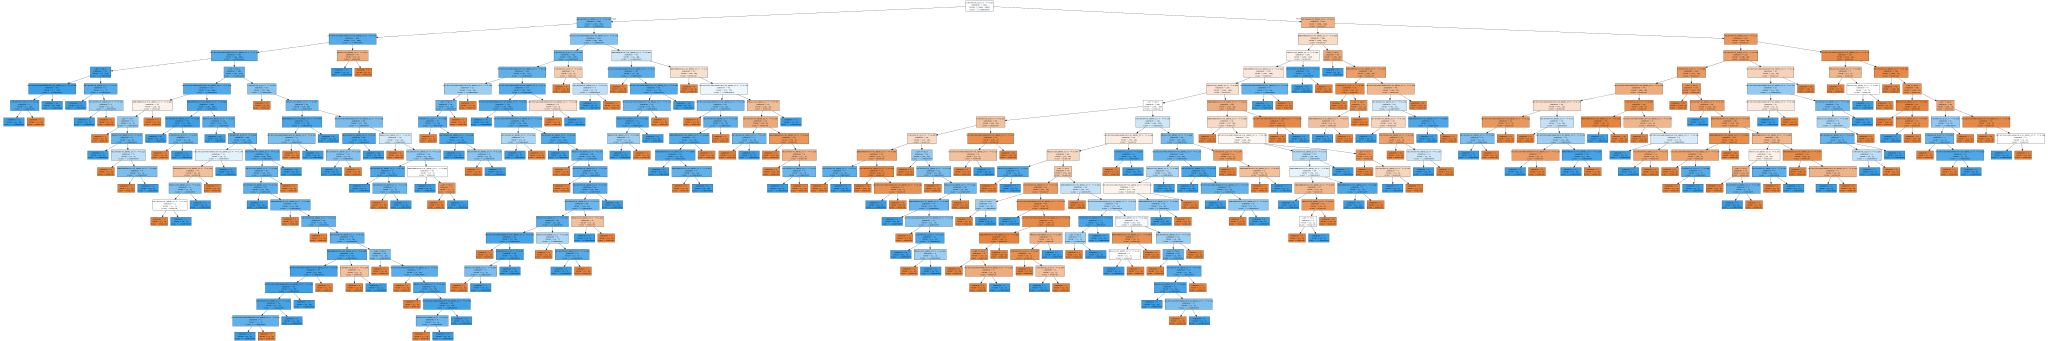

In [20]:
estimator = final_model.estimators_[5]

tree = export_graphviz(estimator, out_file=None, 
                class_names=["Healthy", "Alzheimer's"],
                feature_names=['lhCortexVol_norm_ICV','rhCortexVol_norm_ICV','CortexVol_n_ICV','TotalGray_norm_ICV','SupraTentorialVol_norm_ICV','lhCorticalWhiteMatterVol_norm_ICV','rhCorticalWhiteMatterVol_norm_ICV','Age'],
                impurity=False,
                filled=True)

graph = graphviz.Source(tree)
graph.render('DecTree')  # creates PDF
graph  # in Jupyter

# Predict AD in Cognitively Normal Patients

In [21]:
x = first_instance_df.drop('Subject', axis =1) # first instances FS data to feed back into model
X = x.drop('Diagnosis', axis =1)

prediction = final_model.predict(X) # predict diagnosis of first instances

counts = Counter(prediction) # counts number of AD diag, number of cog norm
print(counts)

Counter({1: 96, 0: 49})


In [22]:
print('Accuracy: ' + str(round(counts[1] / (counts[1]+counts[0]) *100,2)) + '%' )

Accuracy: 66.21%


In [23]:
def color_red(val):
    color = 'red' if val == '97.93' else 'black'
    return 'color: %s' % color

In [24]:
result_df = pd.DataFrame({
    '': ['Model','Pre-Diagnosis Prediction'],
    'Accuracy': [accuracy, '66.21'],
    'Precision': [precision, '-'],
    'Recall': [recall, '-']
 })
result_df = result_df.set_index('')
result_df.style.background_gradient(cmap='GnBu', low=1, high=0.75, axis=0).set_properties(**{'font-size':'15pt'}).applymap(color_red)

,Accuracy,Precision,Recall
,,,
Model,93.16,88.61,99.17
Pre-Diagnosis Prediction,66.9,-,-
